# Estimate New Line Sales Return

I thought that a Gaussian distribution might not be the best idea when I was first modelling, however it is an easy model to fit and understand, with fewer parameters. This time I decided to try getting a Poisson distribution to work, I also noticed that I had used the wrong file in the first estimate and also given the model a skewed dataset, so it was fitting to £35 = 0 counts, when it should have been ignoring £35. With these two errors corrected and the Poisson working I ran the model again.

I also thought that the binned values were not representing the data very well so I reduced the number of bins and refit the distribution. Again, this gives a simple function that can be used to estimate the sales of the new line, assuming people purchase products in a roughly poisson distribution.

Notebook 5. now has a more accurate sales prediction.

### Import packages, read pickle

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
import scipy.optimize as opt
import pickle
pd.options.display.max_seq_items = 2000

In [2]:
openfile=open( r"C:\Users\Joseph\Documents\Beamly\TakeHomeTask\beamly_case_study2.pickle", "rb")
df=pickle.load(openfile)
openfile.close()

### make dataset
look at avg_price still as the estimator, this time want to take out 0s from histogram.

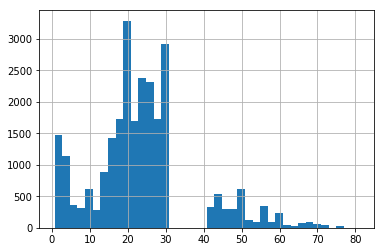

In [3]:
df['avg_price'].hist(bins=40)

In [4]:
data=df['avg_price'].values

In [5]:
data = data[np.isfinite(data)]

In [6]:
data

array([29.95, 27.95, 27.95, ..., 15.9 , 24.5 , 24.95])

### Modelling

This time I will estimate sales for the missing band using a poisson distribution.

In [7]:
from scipy.misc import factorial
from scipy.optimize import minimize, curve_fit

def poisson(k, paras):#paras[0]=lambda, paras[1]=shift, paras[2]=Amplitude
    """poisson pdf, parameter lamb is the fit parameter"""
    return paras[2]*(paras[0]**(k+paras[1])/factorial(k+paras[1])) * np.exp(-paras[0])
def gauss(x, p,D):#p[0]=mu,p[1]=st_dev,p[2]=Amplitude
    """gaussian pdf, paras are the fit parameters"""
    return p[2]/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))+D #p[0]=mu (displace x), p[1]=sig (stdev), p[2]=A (amp), D=,meanmag

Create the data from the histogram, then remove the 0s and put into a new dataframe for the fitting process.

In [9]:
y,edges=np.histogram(data,bins=40)
x1=(edges+((edges[1]-edges[0])/2.0))[:-1]

In [10]:
df_forfit=pd.DataFrame(y,index=x1)
df_forfit=df_forfit[df_forfit[0]!=0]
df_forfit

,0
1.7525,1468
3.7575,1137
5.7625,359
7.7675,311
9.7725,617
11.7775,288
13.7825,886
15.7875,1423
17.7925,1731
19.7975,3285


### Fitting Model
Fit the Poisson model to the avg_price data

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  


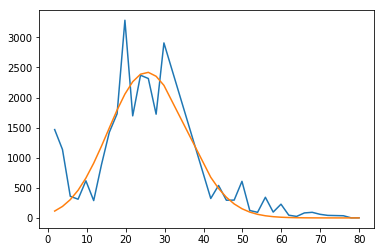

In [11]:
y=df_forfit[0].values
x1=df_forfit.index
o0=[20.,30.,5.]
errfunc = lambda o, x1, y: poisson(x1, o) - y # Distance to the target function, similar to def function.
o1, success = opt.leastsq(errfunc, o0[:], args=(x1, y)) # p1 gives parameters
plt.figure()
plt.plot(x1,y)
plt.plot(x1,poisson(x1,o1))

In [12]:
Band10_20_avg_price_count=poisson(15,o1)
Band20_30_avg_price_count=poisson(25,o1)
Band30_40_avg_price_count=poisson(35,o1)
Band40_50_avg_price_count=poisson(45,o1)
print(Band10_20_avg_price_count,Band20_30_avg_price_count,Band30_40_avg_price_count,Band40_50_avg_price_count)

1375.8158945526754 2418.17461079001 1555.4567987095302 401.4222357205007


c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  


This has now be re-evaluated using a Poisson dist, it seems a little more accurate at least.

In [13]:
var1=Band30_40_avg_price_count/Band10_20_avg_price_count
var2=Band30_40_avg_price_count/Band20_30_avg_price_count
print(var1,var2)

1.1305704526805618 0.6432359316688746


Can create a very simple function based on the benchmarked sales, to apply to columns in a dataframe

In [14]:
def salescount(B12,B23):
    var1,var2=1.1480768035775815,0.6320780098930814
    return (var1*B12+var2*B23)/2.

### Second Fit attempt

The above fit looks better, but there are some spikes in the data which might be skewing the data.

It now looks like it could be overestimating sales a bit.

So I will change the histogram to have fewer bins, to represent the seperate bands better.

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  


[[1.47753704e-03 1.45010203e-03 5.06281062e-01]
 [1.45010203e-03 1.42656876e-03 4.92806907e-01]
 [5.06281062e-01 4.92806907e-01 3.33597791e+02]] [9.93362585e+01 7.54055617e+01 1.06764638e+05]


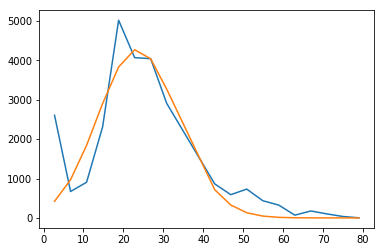

In [15]:
y,edges=np.histogram(data,bins=20)
x1=(edges+((edges[1]-edges[0])/2.0))[:-1]
df_forfit=pd.DataFrame(y,index=x1)
df_forfit=df_forfit[df_forfit[0]!=0]
y=df_forfit[0].values
x1=df_forfit.index
o0=[20.,30.,5.]
errfunc = lambda o, x1, y: poisson(x1, o) - y # Distance to the target function, similar to def function.
fulloutput = opt.leastsq(errfunc, o0[:], args=(x1, y), full_output=1) # p1 gives parameters
o1=fulloutput[0]
covmatrix=fulloutput[1]
print(covmatrix,o1)
plt.figure()
plt.plot(x1,y)
plt.plot(x1,poisson(x1,o1))

Find the avg_price at different positions based on the fitted poisson.

In [16]:
Band10_20_avg_price_count=poisson(15,o1)
Band20_30_avg_price_count=poisson(25,o1)
Band30_40_avg_price_count=poisson(35,o1)
Band40_50_avg_price_count=poisson(45,o1)
print(Band10_20_avg_price_count,Band20_30_avg_price_count,Band30_40_avg_price_count,Band40_50_avg_price_count)
var1=Band30_40_avg_price_count/Band10_20_avg_price_count
var2=Band30_40_avg_price_count/Band20_30_avg_price_count
print(var1,var2)

2958.1372018331476 4222.869023973748 2234.067044156569 479.14358103486694
0.7552276624532916 0.5290400984433794


c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  


This now seems like a good model for estimating sales of the new line and will be implemented into notebook 5, 7 and 8.